In [28]:
from openff.toolkit.topology import Molecule
from rdkit import Chem
from pprint import pprint 
import json

In [29]:
smiles = "CC1=CC(OC2=CC(C(O)=O)=CC(OC)=C2)=CC(OC)=C1"
target_molecule = Molecule.from_smiles(smiles)
target_molecule.generate_conformers(n_conformers=1)
# write to file
target_molecule.to_file(file_path="OA-fragment-4.sdf", file_format="sdf")

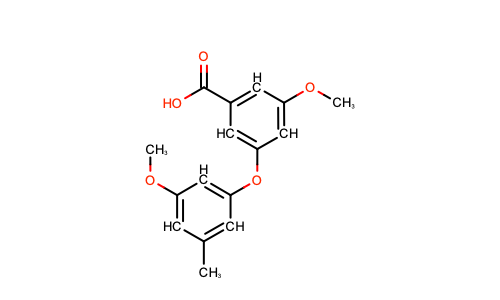

In [30]:
# Visualize the host fragment
# 3D view
offmol = Molecule.from_file('OA-fragment-4.sdf')
#offmol.visualize(backend='nglview')
#offmol

# 2D view of the fragment
offmol.visualize(backend='openeye')

In [31]:
print(f"nAtoms in fragment: {offmol.n_atoms}")

nAtoms in fragment: 37


In [34]:
%%time
# Assign am1bcc partial charges to the fragment, track how much time it takes
offmol.assign_partial_charges(partial_charge_method='am1bcc',
                             use_conformers=offmol.conformers)

# Save the charged fragment to a file
offmol.to_file('frag4_charged.sdf', file_format='sdf')
offmol.to_file('frag4_charged.pdb', file_format='pdb')
offmol.to_file('frag4_charged.mol2', file_format='mol2')

CPU times: user 1.46 s, sys: 18.7 ms, total: 1.48 s
Wall time: 1.5 s


In [35]:
# Input SMARTs of the cap (that was user added -CH3)
cap_submol = Chem.MolFromSmarts('[C:1]([H:2])([H:3])([H:4])') # the cap smarts

# Submol is the whole fragment (fragment 4)
submol = offmol.to_rdkit()

# GetSubstructMatches: Returns tuples of the indices of the molecule’s atoms that
#match a substructure query.
pprint(f"Found {len(submol.GetSubstructMatches(cap_submol))} caps")
submol.GetSubstructMatches(cap_submol)

#submol.RemoveAtom(39)

'Found 3 caps'


((0, 21, 22, 23), (14, 28, 29, 30), (19, 33, 34, 35))

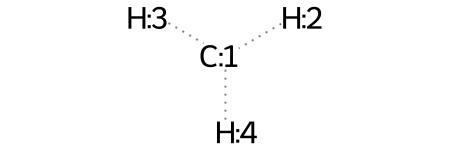

In [36]:
cap_submol
#Chem.MolFromSmarts('[C:1]([H:2])([H:3])([H:4])')

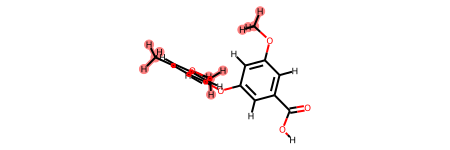

In [37]:
submol

In [44]:
# Load new bespoke parameters
data = json.load(open('../OA-fragment-4/OA-fragment-4_refit_parameter_values.json'))
#pprint(data)

# Load up the torsion smarts
# take first smart
num = 0
smarts = list(data.keys())[num]

# load fragment 4 from sdf
offmol = Molecule.from_file('../OA-fragment-4/OA-fragment-4.sdf')
rdmol = offmol.to_rdkit()
submol = Chem.MolFromSmarts(smarts)

print(rdmol.GetSubstructMatches(submol))

((20, 36, 17, 16, 32, 3, 2, 24, 4, 5, 15, 31, 12, 13, 14, 28, 11, 27, 7, 8, 9, 26, 6, 25, 18, 19, 33, 34, 35, 1, 0, 21, 22, 23), (20, 36, 17, 16, 32, 3, 2, 24, 4, 5, 15, 31, 12, 13, 14, 29, 11, 27, 7, 8, 9, 26, 6, 25, 18, 19, 33, 34, 35, 1, 0, 21, 22, 23), (20, 36, 17, 16, 32, 3, 2, 24, 4, 5, 15, 31, 12, 13, 14, 30, 11, 27, 7, 8, 9, 26, 6, 25, 18, 19, 33, 34, 35, 1, 0, 21, 22, 23))


So, we can map from the atoms in the original structure to the atoms in the parameter SMARTS. 
What we want to do now is to have a representation where we know which atoms in OA-fragment-4
are caps. Once we have their atom indices, we can convert those to atom indices in the SMARTS
and delete them. Then we'll have a SMARTS that will match the whole host molecule.


In [46]:
offmol.atoms # we want to know which atoms in this list are caps

[Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(na

In [52]:
submol_without_caps = Chem.RWMol(submol)
# need to figure out this number for all the caps
#submol_without_caps.RemoveAtom(1)
submol_without_caps

ValueError: bad query type1

In [49]:
Chem.MolToSmarts(submol_without_caps)

'[#6&H1&X3&x2&r6&+0&a:1](-&!@[#1&H0&X1&x0&!R&+0&A])(:&@[#6&H0&X3&x2&r6&+0&a](:&@[#6&H1&X3&x2&r6&+0&a](-&!@[#1&H0&X1&x0&!R&+0&A]):&@[#6&H0&X3&x2&r6&+0&a](:&@[#6&H1&X3&x2&r6&+0&a]-&!@[#1&H0&X1&x0&!R&+0&A])-&!@[#8&H0&X2&x0&!R&+0&A]-&!@[#6&H0&X3&x2&r6&+0&a](:&@[#6&H1&X3&x2&r6&+0&a](-&!@[#1&H0&X1&x0&!R&+0&A]):&@[#6&H0&X3&x2&r6&+0&a](-&!@[#6&H0&X3&x0&!R&+0&A,#8&H0&X2&x0&!R&+0&A]-&!@[#6&H3&X4&x0&!R&+0&A,#8&H1&X2&x0&!R&+0&A]-&!@[#1&H0&X1&x0&!R&+0&A]):&@[#6&H1&X3&x2&r6&+0&a](-&!@[#1&H0&X1&x0&!R&+0&A]):&@[#6&H0&X3&x2&r6&+0&a]-&!@[#6&H0&X3&x0&!R&+0&A,#8&H0&X2&x0&!R&+0&A]-&!@[#6&H3&X4&x0&!R&+0&A,#8&H1&X2&x0&!R&+0&A]-&!@[#1&H0&X1&x0&!R&+0&A]):&@[#6&H1&X3&x2&r6&+0&a]-&!@[#1&H0&X1&x0&!R&+0&A])-&!@[#8&H0&X2&x0&!R&+0&A]-&!@[#6&H3&X4&x0&!R&+0&A](-&!@[#1&H0&X1&x0&!R&+0&A])(-&!@[#1&H0&X1&x0&!R&+0&A])-&!@[#1&H0&X1&x0&!R&+0&A]):&@[#6&H0&X3&x2&r6&+0&a:2]-&!@[#6&H3&X4&x0&!R&+0&A:3](-&!@[#1&H0&X1&x0&!R&+0&A])(-&!@[#1&H0&X1&x0&!R&+0&A])-&!@[#1&H0&X1&x0&!R&+0&A:4]'

In [50]:
smarts

'[#6H1X3x2r6+0a:1](-;!@[#1H0X1x0!r+0A])(:;@[#6H0X3x2r6+0a](:;@[#6H1X3x2r6+0a](-;!@[#1H0X1x0!r+0A]):;@[#6H0X3x2r6+0a](:;@[#6H1X3x2r6+0a]-;!@[#1H0X1x0!r+0A])-;!@[#8H0X2x0!r+0A]-;!@[#6H0X3x2r6+0a](:;@[#6H1X3x2r6+0a](-;!@[#1H0X1x0!r+0A]):;@[#6H0X3x2r6+0a](-;!@[#6H0X3x0!r+0A,#8H0X2x0!r+0A]-;!@[#6H3X4x0!r+0A,#8H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A]):;@[#6H1X3x2r6+0a](-;!@[#1H0X1x0!r+0A]):;@[#6H0X3x2r6+0a]-;!@[#6H0X3x0!r+0A,#8H0X2x0!r+0A]-;!@[#6H3X4x0!r+0A,#8H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A]):;@[#6H1X3x2r6+0a]-;!@[#1H0X1x0!r+0A])-;!@[#8H0X2x0!r+0A]-;!@[#6H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A]):;@[#6H0X3x2r6+0a:2]-;!@[#6H3X4x0!r+0A:3](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A:4]'